Last Change: 2020/02/06 16:50:44.

auther: tsuyo-pon

# IFFT
フーリエ変換を行ったら，逆フーリエ変換をしたくなります．
だって人間だもの．

ということで逆フーリエ変換について説明していきます．

新規の内容はContentsの太字部分です．

序盤は重複する内容があるので，各人の状況に合わせて読み進めてください．
## Contents
1. サイン波の生成(Make a sine wave)
1. サイン波の合成(Make a synthesized sine wave)
1. 高速フーリエ変換(Fast Fourier transform)
1. **逆フーリエ変換(Inverse Fourier transform)**

## サイン波の生成(Make a sine wave)
まずは簡単なサイン波を生成しましょう．
サイン波の式は以下の通りです．

$$
s(t) = A\sin(2{\pi}ft) \tag{1}
$$

数式の説明は以下の通りです．
- A: 振幅
- f: 周波数・振動数
- t: 時刻

ただ，時刻tをそのまま扱うのは難しいので，以下の式でサンプル数に変換しましょう．
- *時間は連続値ですが，デジタルで扱うには離散値にしなければなりません*

$$
t=\frac{n}{f_s} \tag{2}
$$

数式の説明は以下の通りです．
- n: サンプル番号
- fs: サンプリング周波数

①式に②を代入することで，サンプルの時点でのサイン波の振幅が計算できます．

$$
s(n)=A \sin\left(\frac{2{\pi}fn}{f_s}\right)
$$

この式をプログラムで再現すれば，サイン波を生成できます．
- *作りたいサイン波に合わせて，振幅や振動数の値を変化させて見よう!*

In [1]:
from numpy import array, arange, sin, pi
a = 0.5     # 振幅
f = 440     # 周波数
fs = 8000   # サンプリング周波数
sec = 1     # サイン波の持続時間
data = array([
    a * sin(2 * pi * f * n / fs)
    for n in arange(sec * fs)
])
print(data.size)  # 一秒分のサイン波を生成しているので当然 fs と同じ数になる

8000


生成されたサイン波を見てみましょう．
dataは8000個もあって大変みづらいので，最初の80個だけ見てみましょう．
- *1秒で8000個のサンプルがあるところを，80個だけ見るので0.01秒ですね!*
- 横軸: 時間
- 縦軸: 振幅

In [2]:
import matplotlib.pyplot as plt

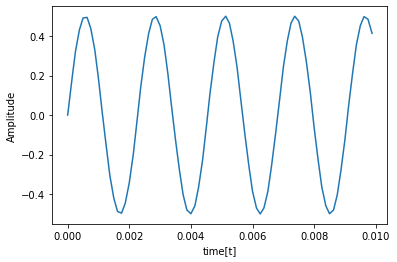

In [3]:
time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

よく見るサイン波が描けましたね!

In [4]:
# 以下お遊び
import IPython.display
from ipywidgets import interact

@interact(f=440, sec=1)
def func(f, sec):
    a = 5
    fs = 8000   # サンプリング周波数
    data = array([
        a * sin(2 * pi * f * n / fs)
        for n in arange(sec * fs)
    ])
    return IPython.display.Audio(data, rate=fs)

interactive(children=(IntSlider(value=440, description='f', max=1320, min=-440), IntSlider(value=1, descriptio…

## サイン波の合成(Make a synthesized sine wave)
先ほど適当な振幅やら周波数やらでサイン波を生成しました．

次は，いろんなサイン波を作って混ぜてみましょう!

In [5]:
a = 0.5                   # 振幅
f_list = [262, 330, 392]  # まぜる周波数
fs = 8000                 # サンプリング周波数
sec = 1                   # サイン波の持続時間

amp = float(a) / len(f_list) # まぜる時の振幅
data = []
for n in arange(sec * fs):
    s = 0.0
    for f in f_list:
        s += amp * sin(2 * pi * f * n / fs)
    data.append(s)
data = array(data)

合成されたサイン波を見てみましょう．

これまたdataは8000個もあって大変みづらいので，最初の80個だけ見てみましょう．
- *サンプリング周波数fsも持続時間secも変化させなければ，横軸timeも変わりません*
- 横軸: 時間
- 縦軸: 振幅

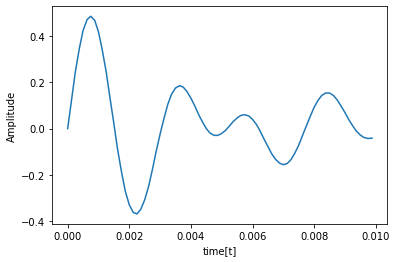

In [6]:
time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

単調なサイン波より複雑な波形が確認できました!

## 高速フーリエ変換(Fast Fourier transform)
複雑な波形を生成しました．
これを解析するには，FFtが必要です．

何はともあれひとまずやってみましょう

まずは先ほども作った合成波を準備します．

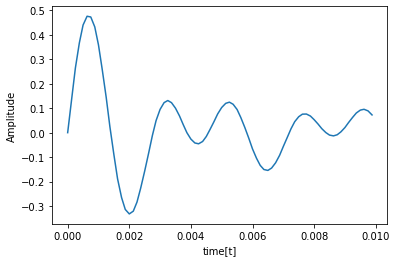

In [7]:
a = 0.5                        # 振幅
f_list = [262, 330, 392, 440]  # まぜる周波数
fs = 8000                      # サンプリング周波数
sec = 1                        # サイン波の持続時間

amp = float(a) / len(f_list) # まぜる時の振幅
data = []
for n in arange(sec * fs):
    s = 0.0
    for f in f_list:
        s += amp * sin(2 * pi * f * n / fs)
    data.append(s)
data = array(data)

time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

これに対して，高速フーリエ変換をします．

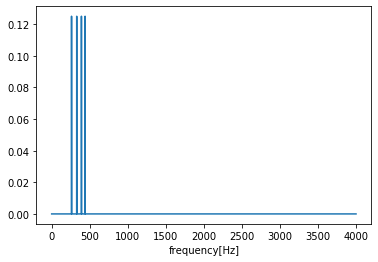

In [8]:
from numpy import abs
from scipy import fftpack

yf = fftpack.fft(data)/(len(data)/2)
freq = fftpack.fftfreq(len(data), fs)
plt.plot(
    array(range(1, int(len(data)/2))),
    abs(yf[1: int(len(data)/2)])
)
plt.xlabel("frequency[Hz]")
plt.show()

一般的に波をフーリエ変換したものをスペクトルと言います．
- 横軸: 周波数
- 縦軸: 成分の強さ

どうでしょう?
スペクトル上では，先ほど合成した周波数の数だけ棒が立っていませんか?

これこそが，高速フーリエ変換が行なっていること．

つまり波形にどんな周波数が，含まれているのかを教えてくれるのです．
- *今回はそれぞれの周波数が同様の割合で存在するので，各成分の強さが等しいのです*

## 逆フーリエ変換(Inverse Fourier transform)
高速フーリエ変換でスペクトル情報を得ました．

スペクトル情報を音声波形に戻す処理を逆フーリエ変換と言います．

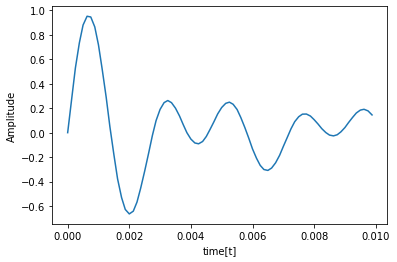

In [9]:
from numpy import real
y = real(fftpack.ifft(yf) * len(data))
plt.plot(time[0:80], y[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

元の波形によく似た音声波形を得ることができました．
- *フーリエ変換をしたのちにスペクトル情報に手を加えて逆フーリエ変換すると，雑に音声変換することができます．*

[Back](fft.ipynb)
/
[Home](../)
/
[Next](bandpass.ipynb)